In [1197]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import json
import types
import copy
from enum import Enum


In [1198]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [1199]:
class Sigmoid:
	"""Implementation of the sigmoid function.
	"""
	def activation(self, x):
		return scipy.special.expit(x)

	def derrivative(self, x):
		return x * (1 - x)

class ActivationFunctions(Enum):
	"""Enumeration to keep track of implemented activation 
	functions for initial model validation.
	"""
	sigmoid = Sigmoid()

In [1200]:
class AutoEncoder:
	"""Abstract implementation of an autoencoder network.
	"""

	def __init__(self, spec:dict=None, learning_rate:int=0.05):
		if spec:
			if not "input" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one input layer.")
			if not "hidden" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one hidden layer.")
			if not "output" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one output layer.")
			if 0 in [layer["nodes"] for layer in spec["layers"]]:
				raise ValueError("All layers must contain at least one node.")
			if len(list(set([layer["activation_func"] for layer in spec["layers"][1:]]).difference(ActivationFunctions._member_names_))):
				raise NotImplementedError(
					f"One or more specified activation functions are not implemented. Implemented functions include: {', '.join(ActivationFunctions._member_names_)}"
				)

			self.spec = spec
			self.learning_rate = learning_rate
			
			for i, layer in enumerate(spec["layers"]):
				if i < len(spec["layers"]) - 1:
					next_layer = spec["layers"][i+1]
					self.spec["layers"][i]["weights"] = np.random.normal(
						loc=0.0, 
						scale=pow(layer["nodes"], -0.5), 
						size=(next_layer["nodes"], layer["nodes"])
					)
			self.model_summary()
	
	def train(self, instances:list, epochs:int=1) -> None:
		"""Trains model using input instances and labels.

		Args:
			instances (list): tensor of input instances.
			epochs (int, optional): number of epochs for which to
			train the model. Defaults to 1.
		"""
		print("\n".join([
			"========================================",
			"Training Model",
			"========================================",
		]))
		for epoch in range(epochs):
			print(f"Epoch: {epoch}/{epochs}")
			for i, instance in enumerate(instances):
				if (((i+1)/len(instances)) * 100) % 25 == 0:
					print(f"Progress: {((i+1)/len(instances)) * 100}%")
				
				activations = self.forward_pass(instance)
				self.backpropogate(instance, activations)

	def forward_pass(self, instance:list) -> list:
		"""Conducts a forward pass through the model,
		generating activations for hidden and output
		layer(s).

		Args:
			instance (list): instance for which to conduct forward 
			pass.

		Returns:
			list: list of dictionaries containing activations
			at each layer.
		"""
		activations = copy.deepcopy(self.spec["layers"])
		for i, layer in enumerate(activations):
			if layer["type"] == "input":
				activations[i]["activations"] = np.array(instance, ndmin=2)
			else:
				activation_func = ActivationFunctions[layer["activation_func"]].value
				inputs = np.dot(activations[i-1]["weights"], activations[i-1]["activations"].T)
				activations[i]["activations"] = activation_func.activation(inputs).T
		return activations

	def backpropogate(self, instance:list, activations:list) -> None:
		"""Adjusts model weights through backpropogation.
		Implemented backpropogation assumes sigmoid activation
		functions.

		Args:
			instance (list): instance for which to backpropogate.
			activations (list): list of dictionaries containing activations
			at each layer. Output by self.forward_pass.
		"""
		for i, layer in reversed(list(enumerate(activations))[1:]):
			if layer["type"] == "output":
				activations[i]["errors"] = np.array(instance, ndmin=2).T - layer["activations"].T
			else:
				activations[i]["errors"] = np.dot(layer["weights"].T, activations[i+1]["errors"])

			activation_func = ActivationFunctions[layer["activation_func"]].value
			
			self.spec["layers"][i-1]["weights"] += self.learning_rate * (
				np.dot(
					activations[i]["errors"] * activation_func.derrivative(activations[i]["activations"].T),
					activations[i-1]["activations"]
				)
			)

	def query(self, instance:list) -> None:
		"""Queries the trained model to encode and reconstruct
		an input instance.

		Args:
			instance (list): instance to resconstruct.
		"""
		activations = self.forward_pass(instance)
		reconstructed_instance = activations[-1]["activations"].T

		fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=2, sharey=True, sharex=True)
		for ax, img in zip(axes.flatten(), [instance, reconstructed_instance]):
			ax.xaxis.set_visible(False)
			ax.yaxis.set_visible(False)
			im = ax.imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray"))  

	def save(self, dir_path:str) -> None:
		"""Writes trained model spec to json.
		
		Args:
			dir_path (str): path to directory in which to save model.
		"""
		with open(f"{dir_path}{self.spec['name']}.json", "w") as f:
			json.dump(self.spec, f, cls=NumpyEncoder)
			print(f"Model saved to {dir_path}{self.spec['name']}.json.")

	def load(self, path_to_spec:str) -> dict:
		"""Loads in a trained model from json specification file.

		Args:
			path_to_spec (str): path to json specification file.

		Returns:
			dict: trained model specification.
		"""
		print(f"Loading model from: {path_to_spec} ...")
		with open(path_to_spec) as f:
			spec = json.load(f)
			for i, layer in enumerate(spec["layers"][:-1]):
				spec["layers"][i]["weights"] = np.asarray(spec["layers"][i]["weights"])
			self.spec = spec
			self.model_summary()
	
	def evaluate(self, instances, labels):
		pass

	def model_summary(self):
		print("\n".join([
			"========================================",
			"Model summary: {}".format(self.spec["name"]),
			"========================================",
			*["{} layer:	{} nodes".format(layer["type"].title(), layer["nodes"]) for layer in self.spec["layers"]],
			"========================================",
		]))

In [1201]:
def load_mnist_data(file_path:str, nrows:int=0) -> tuple[list, list]:
	"""Reads in MNIST dataset, aquired from: 
	https://www.kaggle.com/datasets/oddrationale/mnist-in-csv.

	Args:
		file_path (str): file path to the dataset.
		nrows (int, optional): number of rows to read in. 
		Defaults to all rows.

	Returns:
		tuple[list, list]: image instances, and corresponding 
		one-hot encoded labels.
	"""
	if nrows:
		df = pd.read_csv(filepath_or_buffer=file_path, nrows=nrows)
	else: 
		df = pd.read_csv(filepath_or_buffer=file_path)
	x = ((df[df.columns[1:]]/255 * 0.99) + 0.01).to_numpy()
	y = pd.get_dummies(df["label"]).to_numpy()
	return x, y

x_train, y_train = load_mnist_data(
	file_path="data/mnist_train.csv",
	# nrows=10000
)
x_test, y_test = load_mnist_data(
	file_path="data/mnist_test.csv",
	nrows=100,
)

In [1210]:
base_spec = {
	"name": None,
	"layers": [
		{ "type": "input", "nodes": 784 },
		{ "type": "hidden", "nodes": None, "activation_func": "sigmoid" },
		{ "type": "output", "nodes": 784, "activation_func": "sigmoid" },
	],
}

for hidden_nodes in [2, 4, 8, 16, 32, 64, 128]:
	spec = base_spec
	spec["name"] = f"hl_{hidden_nodes}"
	spec["layers"][1]["nodes"] = hidden_nodes
	model = AutoEncoder(spec, 0.05)
	model.train(instances=x_train, epochs=20)
	model.save(dir_path="./models/")


Model summary: hl_2
Input layer:	784 nodes
Hidden layer:	2 nodes
Output layer:	784 nodes
Training Model
Epoch: 0/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 1/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 2/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 3/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 4/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 5/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 6/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 7/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 8/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 9/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 10/20
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
Epoch: 11/20
Progress: 25.0%
Progress: 50.0%
Pro

Loading model from: ./models/hl_4.json ...
Model summary: hl_4
Input layer:	784 nodes
Hidden layer:	4 nodes
Output layer:	784 nodes


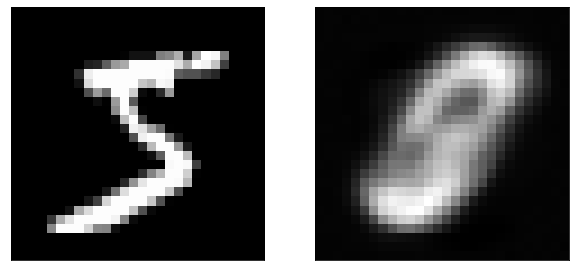

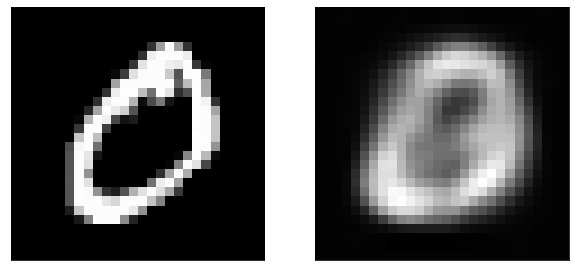

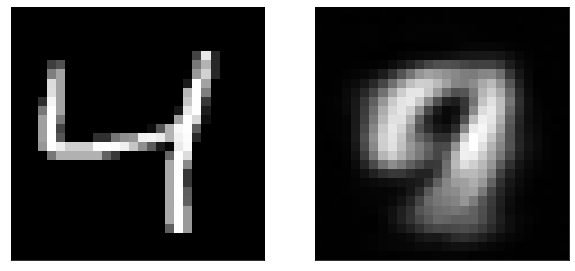

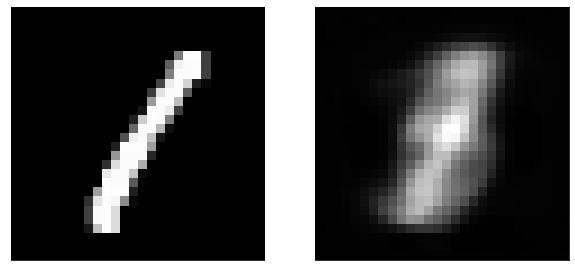

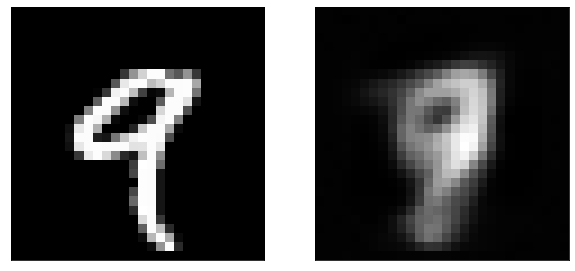

In [1212]:
model = AutoEncoder()
model.load("./models/hl_4.json")
for i in range(0, ):
	model.query(instance=x_train[i])